# Data sets and models

In [1]:
#| default_exp experiments

In [2]:
#| hide 
%load_ext autoreload
%autoreload 2

In [3]:
#| hide
from nbdev.showdoc import *


In [4]:
#| export

from typing import Dict, List, Tuple

from pathlib import Path

import numpy as np

## Data set discovery using Prefix Trees

Data sets are discovered based on being folders within the provided data set root directory which contain subdirectories that start with `cleaned_`.  

Once the data sets are discovered, we take the `cleaned_<feature>` subdirectories and use the `<feature>` as the feature name. 

Then we take the files within the `cleaned_<feature>` subdirectories and discover the ids that data set has for that feature. These do not need to be the same across features, hence all of our data getters might also return `None`.

Automagic ID discovery is done using a prefix tree, which is a data structure that allows for efficient searching of strings based on their prefixes.

In [5]:
#| export

from copy import deepcopy
import warnings

class SimplifiablePrefixTree:
    """A standard prefix tree with the ability to "simplify" itself by combining nodes with only one child.

    These also have the ability to "flatten" themselves, which means to convert all nodes at and below a certain depth into leaves on the most recent ancestor of that depth.

    Parameters
    ----------
    delimiter : str
        The delimiter to use when splitting words into characters. If empty, the words are treated as sequences of characters.
    key : str
        The key of the current node in its parent's `.children` dictionary. If empty, the node is (likely) the root of the tree.
    
    Attributes
    ----------
    key : str
        The key of the current node in its parent's `.children` dictionary. If empty, the node is (likely) the root of the tree.
    children : Dict[str, SimplifiablePrefixTree]
        The children of the current node, stored in a dictionary with the keys being the children's keys.
    is_end_of_word : bool
        Whether the current node is the end of a word. Basically, is this a leaf node?
    delimiter : str
        The delimiter to use when splitting words into characters. If empty, the words are treated as sequences of characters.
    print_spacer : str
        The string to use to indent the printed tree.
    
    Methods
    -------
    chars_from(word: str) -> List[str]
        Splits a word into characters, using the `delimiter` attribute as the delimiter.
    insert(word: str) -> None
        Inserts a word into the tree.
    search(word: str) -> bool
        Searches for a word in the tree.
    simplified() -> SimplifiablePrefixTree
        Returns a simplified copy of the tree. The original tree is not modified.
    simplify() -> SimplifiablePrefixTree
        Simplifies the tree in place.
    reversed() -> SimplifiablePrefixTree
        Returns a reversed copy of the tree, except with with `node.key` reversed versus the node in `self.children`. The original tree is not modified.
    flattened(max_depth: int = 1) -> SimplifiablePrefixTree
        Returns a Tree identical to `self` up to the given depth, but with all nodes at + below `max_depth` converted into leaves on the most recent acestor of lepth `max_depth - 1`.
    _pushdown() -> List[SimplifiablePrefixTree]
        Returns a list corresponding to the children of `self`, with `self.key` prefixed to each child's key.
    print_tree(indent=0) -> str
        Prints the tree, with indentation.
    """
    def __init__(self, delimiter: str = "", key: str = ""):
        self.key = key
        self.children: Dict[str, SimplifiablePrefixTree] = {}
        self.is_end_of_word = False
        self.delimiter = delimiter
        self.print_spacer = "++"
    
    def chars_from(self, word: str):
        return word.split(self.delimiter) if self.delimiter else word

    def insert(self, word: str):
        node = self
        for char in self.chars_from(word):
            if char not in node.children:
                node.children[char] = SimplifiablePrefixTree(self.delimiter, key=char)
            node = node.children[char]
        node.is_end_of_word = True

    def search(self, word: str) -> bool:
        node = self
        for char in self.chars_from(word):
            if char not in node.children:
                return False
            node = node.children[char]
        return node.is_end_of_word
    
    def simplified(self) -> 'SimplifiablePrefixTree':
        self_copy = deepcopy(self)
        return self_copy.simplify()
    
    def simplify(self):
        if len(self.children) == 1 and not self.is_end_of_word:
            child_key = list(self.children.keys())[0]
            self.key += child_key
            self.children = self.children[child_key].children
            self.simplify()
        else:
            current_keys = list(self.children.keys())
            for key in current_keys:
                child = self.children.pop(key)
                child.simplify()
                self.children[child.key] = child
        return self
    
    def reversed(self) -> 'SimplifiablePrefixTree':
        rev_self = SimplifiablePrefixTree(self.delimiter, key=self.key[::-1])
        rev_self.children = {k[::-1]: v.reversed() for k, v in self.children.items()}
        return rev_self
    
    def flattened(self, max_depth: int = 1) -> 'SimplifiablePrefixTree':
        """Returns a Tree identical to `self` up to the given depth, but with all nodes at + below `max_depth` converted into leaves on the most recent acestor of lepth `max_depth - 1`.
        """
        flat_self = SimplifiablePrefixTree(self.delimiter, key=self.key)
        if max_depth == 0:
            if not self.is_end_of_word:
                warnings.warn(f"max_depth is 0, but {self.key} is not a leaf.")
            return flat_self
        if max_depth == 1:
            for k, v in self.children.items():
                if v.is_end_of_word:
                    flat_self.children[k] = SimplifiablePrefixTree(self.delimiter, key=k)
                else:
                    # flattened_children = v._pushdown()
                    for flattened_child in v._pushdown():
                        flat_self.children[flattened_child.key] = flattened_child
        else:
            for k, v in self.children.items():
                flat_self.children[k] = v.flattened(max_depth - 1)
        return flat_self
    
    def _pushdown(self) -> List['SimplifiablePrefixTree']:
        """Returns a list corresponding to the children of `self`, with `self.key` prefixed to each child's key.
        """
        pushed_down = [
            c
            for k in self.children.values()
            for c in k._pushdown()
        ]
        for i in range(len(pushed_down)):
            pushed_down[i].key = self.key + self.delimiter + pushed_down[i].key

        if not pushed_down:
            return [SimplifiablePrefixTree(self.delimiter, key=self.key)]
        else:
            return pushed_down
            

    def __str__(self):
        # prints .children recursively with indentation
        return self.key + "\n" + self.print_tree()

    def print_tree(self, indent=0) -> str:
        result = ""
        for key, child in self.children.items():
            result +=  self.print_spacer * indent + "( " + child.key + "\n"
            result += SimplifiablePrefixTree.print_tree(child, indent + 1)
        return result


class IdExtractor(SimplifiablePrefixTree):
    """Class extending the prefix trees that incorporates the algorithm for extracting IDs from a list of file names. The algorithm is somewhat oblique, so it's better to just use the `extract_ids` method versus trying to use the prfix trees directly at the call site.
    
    The algorithm is based on the assumption that the IDs are the same across all file names, but that the file names may have different suffixes. The algorithm reverses the file names, inserts them into the tree, and then simplifes and flattens that tree in order to find the IDs as leaves of that simplified tree.

    1. Insert the file name string into the tree, but with each string **reversed**.
    2. Simplify the tree, combining nodes with only one child.
    3. There may be unexpected suffix matches for these IDs, so we flatten the tree to depth 1, meaning all children of the root are combined to make leaves.
    4. The leaves are the IDs we want to extract. However, we must reverse these leaf keys to get the original IDs, since we reversed the file names in step 1.

    TODO:
    * If we want to find IDs for files with differing prefixes instead, we should instead insert the file names NOT reversed and then NOT reverse in the last step.

    * To handle IDs that appear in the middle of file names, we can use both methods to come up with a list of potential IDs based on prefix and suffix, then figure out the "intersection" of those lists. (Maybe using another prefix tree?)

    """
    def __init__(self, delimiter: str = "", key: str = ""):
        super().__init__(delimiter, key)

    def extract_ids(self, files: List[str]) -> List[str]:
        for file in files:
            self.insert(file[::-1])
        return sorted([
            c.key for c in self
                .prefix_flattened()
                .children
                .values()
        ])
    
    def prefix_flattened(self) -> 'IdExtractor':
        return self.simplified().flattened(1).reversed()
    

In [6]:
#| test
entries = [
    '3XYZabc12',
    '3XY&abc12',
    '3XYAabc12',
    '3XYBabc12',
    'MMVQabc12',
    'NMVQabc12',
]

expected_ids = sorted([
    '3XYZ',
    '3XY&',
    '3XYA',
    '3XYB',
    'MMVQ',
    'NMVQ',
])

id_extractor = IdExtractor()

ids = id_extractor.extract_ids(entries)

for i, (expected, actual) in enumerate(zip(expected_ids, ids)):
    assert expected == actual, f"Expected {expected}, but got {actual} at index {i}"


In [7]:
#| hide
print(id_extractor)


( 2
++( 1
++++( c
++++++( b
++++++++( a
++++++++++( Z
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( &
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( A
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( B
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( Q
++++++++++++( V
++++++++++++++( M
++++++++++++++++( M
++++++++++++++++( N



In [8]:
#| hide
print(id_extractor.prefix_flattened())

abc12
( 3XYZ
( 3XY&
( 3XYA
( 3XYB
( MMVQ
( NMVQ



In [9]:
#| export

import os
import re
import polars as pl
from typing import DefaultDict, Iterable
from collections import defaultdict
import logging

from pisces.utils import determine_header_rows_and_delimiter

LOG_LEVEL = logging.INFO

class DataSetObject:
    FEATURE_PREFIX = "cleaned_"

    # Set up logging
    logger = logging.getLogger(__name__)
    logger.setLevel(LOG_LEVEL)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    def __init__(self, name: str, path: Path):
        self.name = name
        self.path = path
        self.ids: List[str] = []

        # keeps track of the files for each feature and user
        self._feature_map: DefaultDict[str, Dict[str, str]] = defaultdict(dict)
        self._feature_cache: DefaultDict[str, Dict[str, pl.DataFrame]] = defaultdict(dict)
    
    @property
    def features(self) -> List[str]:
        return list(self._feature_map.keys())
    
    def __str__(self):
        return f"{self.name}: {self.path}"

    def get_feature_data(self, feature: str, id: str) -> pl.DataFrame | None:
        if feature not in self.features:
            warnings.warn(f"Feature {feature} not found in {self.name}. Returning None.")
            return None
        if id not in self.ids:
            warnings.warn(f"ID {id} not found in {self.name}")
            return None
        if (df := self._feature_cache[feature].get(id)) is None:
            file = self.get_filename(feature, id)
            if not file:
                return None
            self.logger.debug(f"Loading {file}")
            try:
                n_rows, delimiter = determine_header_rows_and_delimiter(file)
                # self.logger.debug(f"n_rows: {n_rows}, delimiter: {delimiter}")
                df = pl.read_csv(file, has_header=True if n_rows > 0 else False,
                                 skip_rows=max(n_rows-1, 0), 
                                 separator=delimiter)
            except Exception as e:
                warnings.warn(f"Error reading {file}:\n{e}")
                return None
            # sort by time when loading
            df.sort(df.columns[0])
            self._feature_cache[feature][id] = df
        return df

    def get_filename(self, feature: str, id: str) -> Path | None:
        feature_ids = self._feature_map.get(feature)
        if feature_ids is None:
            # raise ValueError(f"Feature {feature_ids} not found in {self.name}")
            print(f"Feature {feature_ids} not found in {self.name}")
            return None
        file = feature_ids.get(id)
        if file is None:
            # raise ValueError
            print(f"ID {id} not found in {self.name}")
            return None
        return self.get_feature_path(feature)\
            .joinpath(file)
    
    def get_feature_path(self, feature: str) -> Path:
        return self.path.joinpath(self.FEATURE_PREFIX + feature)
    
    def _extract_ids(self, files: List[str]) -> List[str]:
        return IdExtractor().extract_ids(files)
    
    def add_feature_files(self, feature: str, files: Iterable[str]):
        if feature not in self.features:
            self.logger.debug(f"Adding feature {feature} to {self.name}")
            self._feature_map[feature] = {}
        # use a set for automatic deduping
        deduped_ids = set(self.ids)
        extracted_ids = sorted(self._extract_ids(files))
        files = sorted(list(files))
        # print('# extracted_ids:', len(extracted_ids))
        for id, file in zip(extracted_ids, files):
            # print('adding data for id:', id, 'file:', file)
            self._feature_map[feature][id] = file
            # set.add only adds the value if it's not already in the set
            deduped_ids.add(id)
        self.ids = sorted(list(deduped_ids))
    
    def get_feature_files(self, feature: str) -> Dict[str, str]:
        return {k: v for k, v in self._feature_map[feature].items()}
    
    def get_id_files(self, id: str) -> Dict[str, str]:
        return {k: v[id] for k, v in self._feature_map.items()}
    
    def load_feature_data(self, feature: str | None, id: str | None) -> Dict[str, np.ndarray]:
        if feature not in self.features:
            raise ValueError(f"Feature {feature} not found in {self.name}")
    
    @classmethod
    def find_data_sets(cls, root: str | Path) -> Dict[str, 'DataSetObject']:
        set_dir_regex = r".*" + cls.FEATURE_PREFIX + r"(.+)"
        # this regex matches the feature directory name and the data set name
        # but doesn't work on Windows (? maybe, cant test) because of the forward slashes
        feature_dir_regex = r".*/(.+)/" + cls.FEATURE_PREFIX + r"(.+)"

        data_sets: Dict[str, DataSetObject] = {}
        for root, dirs, files in os.walk(root, followlinks=True):
            # check to see if the root is a feature directory,
            # if it is, add that feature data to the data set object,
            # creating a new data set object if necessary.
            if (root_match := re.match(feature_dir_regex, root)):
                cls.logger.debug(f"Feature directory: {root}")
                cls.logger.debug(f"data set name: {root_match.group(1)}")
                cls.logger.debug(f"feature is: {root_match.group(2)}", )
                data_set_name = root_match.group(1)
                feature_name = root_match.group(2)
                if (data_set := data_sets.get(data_set_name)) is None:
                    data_set = DataSetObject(root_match.group(1), Path(root).parent)
                    data_sets[data_set.name] = data_set
                files = [f for f in files if not f.startswith(".") and not f.endswith(".tmp")]
                data_set.add_feature_files(feature_name, files)
        
        return data_sets
    



## Model preprocessing

In [10]:
#| export
from numpy.lib.stride_tricks import as_strided

def psg_to_sleep_wake(psg: pl.DataFrame) -> np.array:
    # map all positive classes to 1 (sleep)
    # retain all 0 (wake) and -1 (mask) classes
    return np.where(psg[:, 1] > 0, 1, psg[:, 1])

def get_activity_X_PSG_y(data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
    activity_0 = data_set.get_feature_data("activity", id)
    psg_0 = data_set.get_feature_data("psg", id)

    if activity_0 is None or psg_0 is None:
        return None
    
    # round the time column to the nearest second
    activity_time_col = activity_0.columns[0]
    activity_0 = activity_0.with_columns(pl.col(activity_time_col).round(0))

    psg_time_col = psg_0.columns[0]
    psg_0 = psg_0.with_columns(pl.col(psg_time_col).round(0))

    # trim the activity and psg data to both end when the 0th column (time) of either ends
    start_time = max(activity_0[0, 0], psg_0[0, 0])
    end_time = min(activity_0[-1, 0], psg_0[-1, 0])
    activity_0 = activity_0.filter((activity_0[activity_time_col] <= end_time) & (activity_0[activity_time_col] >= start_time))
    psg_0 = psg_0.filter((psg_0[psg_time_col] <= end_time) & (psg_0[psg_time_col] >= start_time))

    X = activity_0[:, 1].to_numpy()
    # Assuming that X has 15 second epochs, psg has 30 second epochs. So, we fold and sum the X values to match the psg epochs
    # TODO: make this dynamic based on activity_0['time'].diff() and psg_0['time'].diff()
    # make the reshape(-1, 2) non-ragged 
    # remove the last element if the length is odd
    if res := X.shape[0] % 2:
        #! X[:-0] is empty, so don't do this if res == 0
        X = X[:-res] 
    X = X.reshape((-1, 2)).sum(axis=1)
    y = psg_to_sleep_wake(psg_0)

    if X.shape[0] != y.shape[0]:
        # trim the longer one to match
        min_len = min(X.shape[0], y.shape[0])
        if not min_len:
            return None
        X = X[:min_len]
        y = y[:min_len]

    return X, y

def rolling_window(arr, window_size):
    strided_axis_0 = max(arr.shape[0] - window_size + 1, 0)
    arr_strided = as_strided(arr, shape=(strided_axis_0, window_size), strides=(arr.strides[0], arr.strides[0]))
    return arr_strided

In [11]:
#| test
input_vec = np.arange(10)
expected_rolling = np.array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])
rolled = rolling_window(input_vec, 3)


assert np.array_equal(rolled, expected_rolling), f"Expected {expected_rolling}, but got {rolled}"

In [12]:
#| export

import polars as pl
import numpy as np
from scipy.ndimage import gaussian_filter1d

def apply_gausian_filter(df: pl.DataFrame, sigma: float = 1.0, overwrite: bool = False) -> pl.DataFrame:
    data_columns = df.columns[1:]  # Adjust this to match your data column indices

    # Specify the standard deviation of the Gaussian kernel
    sigma = 1.0  # This controls the smoothing. Adjust based on your data's sampling rate and desired smoothing

    # Apply Gaussian smoothing to each data column
    for col in data_columns:
        new_col_name = f"{col}_smoothed" if not overwrite else col
        df = df.with_columns(
            pl.Series(gaussian_filter1d(df[col].to_numpy(), sigma)).alias(new_col_name)
        )
    return df

def fill_gaps_in_accelerometer_data(acc: pl.DataFrame, smooth: bool = False, final_sampling_rate_hz: int | None = None) -> np.ndarray:
    
    # median sampling rate (to account for missing data)
    sampling_period_s = acc[acc.columns[0]].diff().median() # 1 / sampling_rate_hz
    print("sampling_period_s:", sampling_period_s)
    if sampling_period_s == 0.0:
        warnings.warn("Sampling period is 0.0. Returning None.")
        return None
    
    # Step 0: Save the original 'timestamp' column as 'timestamp_raw'
    acc_resampled = acc.with_columns(acc[acc.columns[0]].alias('timestamp'))

    if isinstance(final_sampling_rate_hz, int):
        final_rate_sec = 1 / final_sampling_rate_hz
        print(f"resampling to {final_sampling_rate_hz}Hz ({final_rate_sec:0.5f}s) from {int(1/sampling_period_s)} Hz ({sampling_period_s:0.5f}s)")
        # make a new data frame with the new timestamps
        # do this using linear interpolation

        median_time = acc_resampled['timestamp'].to_numpy()
        final_timestamps = np.arange(median_time.min(), median_time.max() + final_rate_sec, final_rate_sec)
        median_data = acc_resampled[:, 1:4].to_numpy()
        new_data = np.zeros((final_timestamps.shape[0], median_data.shape[1]))
        for i in range(median_data.shape[1]):
            new_data[:, i] = np.interp(final_timestamps, median_time, median_data[:, i])
        acc_resampled = pl.DataFrame({
            'timestamp': final_timestamps, 
            **{
                acc_resampled.columns[i+1]: new_data[:, i] 
                for i in range(new_data.shape[1])
            }})


    if smooth:
        acc_resampled = apply_gausian_filter(acc_resampled, overwrite=True)

    return acc_resampled


sampling_period_s: 0.02
resampling to 50Hz (0.02000s) from 50 Hz (0.02000s)


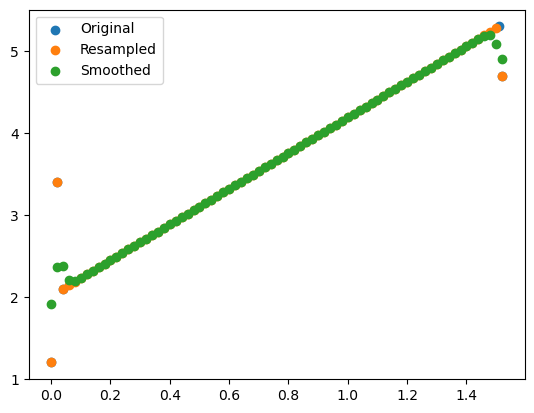

In [13]:
import matplotlib.pyplot as plt

# Assuming 'acc' is your existing Polars DataFrame with the first column as 'timestamp'.
acc = pl.DataFrame({
    "timestamp": [0, 0.02, 0.04, 1.51, 1.52],  # Irregular timestamps
    "sensor1": [1.2, 3.4, 2.1, 5.3, 4.7],
    "sensor2": [0.5, 0.8, 1.1, 0.3, 1.9]
})

acc_resampled = fill_gaps_in_accelerometer_data(acc, final_sampling_rate_hz=50)
acc_resampled = apply_gausian_filter(acc_resampled, overwrite=False)

# Plot the original and resampled timestamps
plt.scatter(acc['timestamp'], acc['sensor1'], label='Original')
plt.scatter(acc_resampled['timestamp'], acc_resampled['sensor1'], label='Resampled')
plt.scatter(acc_resampled['timestamp'], acc_resampled['sensor1_smoothed'], label='Smoothed')
plt.legend()

In [14]:
acc_resampled

timestamp,sensor1,sensor2,sensor1_smoothed,sensor2_smoothed
f64,f64,f64,f64,f64
0.0,1.2,0.5,1.908138,0.62661
0.02,3.4,0.8,2.360776,0.800721
0.04,2.1,1.1,2.377994,0.988355
0.06,2.143537,1.089116,2.212371,1.06949
0.08,2.187075,1.078231,2.19292,1.07677
0.1,2.230612,1.067347,2.230792,1.067305
0.12,2.27415,1.056463,2.27415,1.056463
0.14,2.317687,1.045578,2.317687,1.045578
0.16,2.361224,1.034694,2.361224,1.034694


In [15]:
# make a Gaussian-distributed random vector with 1000 elements
# mean zero, stdev 0.001

normal_vec = np.abs(np.random.normal(0.02, 0.001, 1000))
times = np.cumsum(normal_vec)

In [16]:
y = np.random.normal(0, 1, len(normal_vec))

In [17]:
df = pl.DataFrame({
    "timestamp": times,
    "y": y,
    "cos_y": np.cos(times),
})

In [18]:
df_r = fill_gaps_in_accelerometer_data(df, smooth=False, final_sampling_rate_hz=50)

sampling_period_s: 0.02000634776617538
resampling to 50Hz (0.02000s) from 49 Hz (0.02001s)


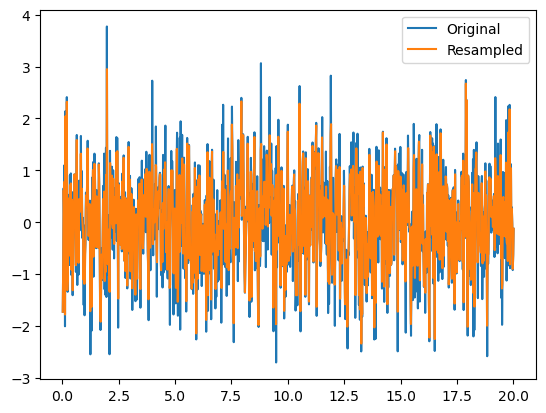

In [19]:
plt.plot(df['timestamp'], df['y'], label='Original')
plt.plot(df_r['timestamp'], df_r['y'], label='Resampled')
plt.legend()

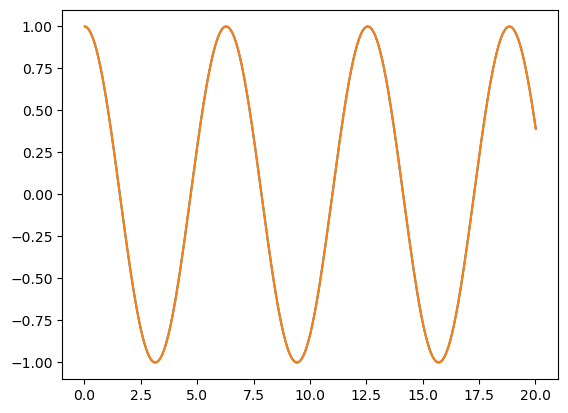

In [20]:
plt.plot(df_r['timestamp'], df_r['cos_y'], label='Resampled')
plt.plot(df['timestamp'], df['cos_y'], label='Original')

## Classifier models

In [21]:
#| export
import abc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
import numpy as np


class SleepWakeClassifier(abc.ABC):
    """
    """
    @abc.abstractmethod
    def get_needed_X_y(self, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        pass
    def train(self, examples_X: List[pl.DataFrame] = [], examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        pass
    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        pass
    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        pass


### SGD Logistic Regression

In [22]:
#| export

class SGDLogisticRegression(SleepWakeClassifier):
    """Uses Sk-Learn's `SGDCLassifier` to train a logistic regression model. The SGD aspect allows for online learning, or custom training regimes through the `partial_fit` method.
     
    The model is trained with a balanced class weight, and uses L1 regularization. The input data is scaled with a `StandardScaler` before being passed to the model.
    """
    def __init__(self, lr: float = 0.15, input_dim: int = 11, output_dim: int = 1):
        self.model = SGDClassifier(loss='log_loss',
                                   learning_rate='adaptive',
                                   penalty='l1',
                                   eta0=lr,
                                   class_weight='balanced',
                                   warm_start=True)
        self.scaler = StandardScaler()
        self.pipeline = make_pipeline(self.scaler, self.model)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.window_step = 1

    def get_needed_X_y(self, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        return get_activity_X_PSG_y(data_set, id)
    
    def _prepare_labels(self, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        y_trimmed = self._trim_labels(y)
        n_sleep = np.sum(y_trimmed > 0)
        n_wake = np.sum(y_trimmed == 0)
        N = n_sleep + n_wake
        # Want to make a balanced weight loss, along with giving 0.0 * loss for masked values (y < 0)
        mask_weights_zero = np.where(y_trimmed < 0, 0.0, 1)
        # balancing_weights_ignore_mask = np.where(y_trimmed > 0, n_wake / N, n_sleep / N)
        balancing_weights_ignore_mask = np.where(y_trimmed > 0, N / n_sleep, N / n_wake)
        sample_weights = mask_weights_zero * balancing_weights_ignore_mask

        y_demasked = np.where(y_trimmed < 0, 0, y_trimmed)

        return y_demasked, sample_weights

    def train(self, examples_X: List[pl.DataFrame] = [], examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        if examples_X or examples_y:
            assert len(examples_X) == len(examples_y)
        if pairs_Xy:
            assert not examples_X
        
        training = []
        training_iterator = iter(pairs_Xy) if pairs_Xy else zip(examples_X, examples_y)
        for X, y in training_iterator:
            try:
                X_folded = self._fold(X)
                y_prepped, sample_weights = self._prepare_labels(y)
                if (X_folded.shape[0] != y_prepped.shape[0]) \
                    or (X_folded.shape[0] == 0) \
                    or (y_prepped.shape[0] == 0):
                    continue
                training.append((X_folded, y_prepped, sample_weights))
            except Exception as e:
                print(f"Error folding or trimming data: {e}")
                continue
        
        Xs = [X for X, _, _ in training]
        ys = [y for _, y, _ in training]
        weights = [w for _, _, w in training]
        Xs = np.concatenate(Xs, axis=0)
        ys = np.concatenate(ys, axis=0)
        weights = np.concatenate(weights, axis=0)

        selector = ys >= 0
        Xs = Xs[selector]
        ys = ys[selector]
        weights = weights[selector]

        self.pipeline.fit(Xs, ys)
    
    def _input_preprocessing(self, X: np.ndarray) -> np.ndarray:
        return self.scaler.transform(self._fold(X))
    
    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return self.model.predict(self._input_preprocessing(sample_X))
    
    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return self.model.predict_proba(self._input_preprocessing(sample_X))
    
    def _fold(self, input_X: np.ndarray | pl.DataFrame) -> np.array:
        if isinstance(input_X, pl.DataFrame):
            input_X = input_X.to_numpy()
        folded_X = rolling_window(input_X, self.input_dim)
        if folded_X.shape[0] == 0:
            warnings.warn(f"input has {input_X.shape[0]} < {self.input_dim} samples. Returning a zero-padded array.")
            padded = np.zeros((1, self.input_dim))
            padded[0, :input_X.shape[0]] = input_X
            folded_X = padded
        return folded_X
    
    def _trim_labels(self, labels_y: pl.DataFrame) -> np.ndarray:
        start, end = self._indices_to_trim()
        # return labels_y[self.input_dim:]
        return labels_y[start:-end]
        
    def _indices_to_trim(self) -> Tuple[int, int]:
        # ex: input_dim = 8 => (4, 3)
        # ex: input_dim = 7 => (3, 3)
        # ex: input_dim = 6 => (3, 2)
        return (self.input_dim // 2, self.input_dim - (self.input_dim // 2))

### Mads Olsen et all classifier

We have downloaded the saved model weights from a [research repository from Mads Olsen's group](https://github.com/MADSOLSEN/SleepStagePrediction), and converted those into a saved Keras model to remove the need to re-define all of the layers. This conversion process is shown in `../analyses/convert_mads_olsen_model_to_keras.ipynb`.

Thus, we have a TensorFlow model that we can run inference on, and we could train it if we wanted to.

For simplicity, we are just going to run inference. One twist of our method is that the classifier is expecting two high-resolution spectrograms for inputs:
1. 3-axis Accelerometer data
2. PPG (photoplethysmogram) data

Based on visually inspecting examples from the paper, we are going to hack together an input by flipping the accelerometer data along the frequencies axis. The paper images seem to show a similarity between high-frequency accelerometer data and low-frequency PPG data. Surprisingly, this seems to work well.

In [23]:
#| export

"""
This section is copied straight from https://github.com/MADSOLSEN/SleepStagePrediction, pulling just the functions needed for the classifier and modifying some of them to work here.
"""

import sys
from functools import partial

import numpy as np
import pandas as pd
from scipy.signal import spectrogram

from functools import partial

import pandas as pd
import tensorflow as tf
import pkg_resources

def median(x, fs, window_size):
    if isinstance(x, pl.DataFrame):
        x = x.to_numpy()

    window = (
        (fs * window_size + 1) if (fs * window_size) % 2 == 0 else (fs * window_size)
    )

    reduce_dims = False
    if len(x.shape) == 1:
        x = np.expand_dims(x, axis=-1)
        reduce_dims = True
    x_norm = np.zeros((x.shape))

    for idx in range(x.shape[-1]):

        x_med = np.ones((x.shape[0])) * np.median(x[:, idx])

        x_pd = pd.Series(x[:, idx])
        med_ = x_pd.rolling(window).median()
        x_med[int(window / 2) : -int(window / 2)] = med_[window - 1 :]
        x_med[: int(window / 2)] = med_[window - 1]
        x_med[-int(window / 2) :] = med_[-1:]

        x_med[np.isnan(x_med)] = 0  # remove nan

        x_norm[:, idx] = x[:, idx] - x_med

    if reduce_dims:
        x_norm = x_norm[:, 0]
    return x_norm


def clip_by_iqr(x, fs, threshold=20):

    x[x > threshold] = threshold
    x[x < -threshold] = -threshold

    return x

def iqr_normalization_adaptive(x, fs, median_window, iqr_window):
    def normalize(x, fs, median_window, iqr_window, iqr_upper=0.75, iqr_lower=0.25):

        # add noise
        x_ = x + np.random.normal(loc=0, scale=sys.float_info.epsilon, size=(x.shape))

        # fix window parameters to odd number
        med_window = (
            (fs * median_window + 1)
            if (fs * median_window) % 2 == 0
            else (fs * median_window)
        )
        iqr_window = (
            (fs * iqr_window + 1) if (fs * iqr_window) % 2 == 0 else (fs * iqr_window)
        )

        # preallocation
        x_med = np.ones((x.shape)) * np.median(x_)
        x_iqr_up = np.ones((x.shape)) * np.quantile(x_, iqr_upper)
        x_iqr_lo = np.ones((x.shape)) * np.quantile(x_, iqr_lower)

        # find rolling median
        x_pd = pd.Series(x_)
        med_ = x_pd.rolling(med_window).median()
        x_med[int(med_window / 2) : -int(med_window / 2)] = med_[med_window - 1 :]
        x_med[np.isnan(x_med)] = 0  # remove nan

        # find rolling quantiles
        x_iqr_upper = x_pd.rolling(iqr_window).quantile(iqr_upper)
        x_iqr_lower = x_pd.rolling(iqr_window).quantile(iqr_lower)

        # border padding
        x_iqr_up[int(iqr_window / 2) : -int(iqr_window / 2)] = x_iqr_upper[
            iqr_window - 1 :
        ]
        x_iqr_lo[int(iqr_window / 2) : -int(iqr_window / 2)] = x_iqr_lower[
            iqr_window - 1 :
        ]

        # remove nan
        x_iqr_up[np.isnan(x_iqr_up)] = 0
        x_iqr_lo[np.isnan(x_iqr_lo)] = 0

        # return normalize
        return (x_ - x_iqr_lo) / (x_iqr_up - x_iqr_lo + sys.float_info.epsilon) * 2 - 1

    x_norm = np.zeros((x.shape))
    if len(x.shape) == 1:
        x_norm[:] = normalize(x, fs, median_window, iqr_window)
    else:
        for n in range(x.shape[1]):
            x_norm[:, n] = normalize(x[:, n], fs, median_window, iqr_window)
    return x_norm



def cal_psd(x, fs, window, noverlap, nfft, f_min, f_max, f_sub=1):
    """
    https://github.com/MADSOLSEN/SleepStagePrediction/blob/d47ff488f5cedd3b0459593a53fc4f92fc3660a2/signal_processing/spectrogram.py#L91
    """
    from scipy.ndimage import maximum_filter as maxfilt

    # border edit
    x_ = np.zeros((x.size + window,))
    x_[window // 2 : -window // 2] = x
    x_ = x_ + np.random.normal(loc=0, scale=sys.float_info.epsilon, size=(x_.shape))

    f, t, S = spectrogram(
        x=x_,
        fs=fs,
        window=np.blackman(window),
        nperseg=window,
        noverlap=noverlap,
        nfft=nfft,
    )

    S = S[(f > f_min) & (f <= f_max), :]
    S = maxfilt(np.abs(S), size=(f_sub, 1))
    S = S[::f_sub, :]
    S = np.swapaxes(S, axis1=1, axis2=0)
    S = np.log(S + sys.float_info.epsilon)
    if S.shape[1] != 24:
        k = 1

    assert np.sum(np.isinf(S)) == 0
    assert np.sum(np.isnan(S)) == 0
    return S

def _load_saved_keras():
    file_path = pkg_resources.resource_filename('pisces', 'cached_models/mo_resunet.keras')

    return tf.keras.models.load_model(file_path, safe_mode=False)


In [24]:
#| export

import multiprocessing
from concurrent.futures import ProcessPoolExecutor


def parallel_execute(func, inputs: List, max_workers: int = None):
    """
    max_workers (int, optional): The number of workers to use for parallel processing. Defaults to None, which uses all available cores. Setting to a negative number leaves that many cores unused. For example, if my machine has 4 cores and I set max_workers to -1, then 3 = 4 - 1 cores will be used; if max_workers=-3 then 1 = 4 - 3 cores are used.
    """
    # Get the number of available CPU cores
    num_cores = multiprocessing.cpu_count()
    workers_to_use = max_workers if max_workers is not None else num_cores
    if (workers_to_use > num_cores):
        warnings.warn(f"Attempting to use {max_workers} but only have {num_cores}. Running with {num_cores} workers.")
        workers_to_use = num_cores
    if workers_to_use <= 0:
        workers_to_use = num_cores + max_workers
    if workers_to_use < 1:
        # do this check second, NOT with elif, to verify we're still in a valid state
        raise ValueError(f"With `max_workers` == {max_workers}, we end up with max_workers + num_cores ({max_workers} + {num_cores}) which is less than 1. This is an error.")

    print(f"{parallel_execute.__name__}: Using {workers_to_use} of {num_cores} cores ({int(100 * workers_to_use / num_cores)}%) for parallel preprocessing.")
    print(f"{parallel_execute.__name__}: This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)")

    # Create a pool of workers
    with ProcessPoolExecutor(max_workers=workers_to_use) as executor:
        results = list(
            executor.map(
                func, 
                inputs
            ))
    return results

In [25]:
#| export

FS = 32
CHANNELS = 2
DEPTH = 9
N_OUT = 2 ** (DEPTH + 1)
N_CLASSES = 4

MO_UNET_CONFIG = {
    "input_shape": (15360, 32, CHANNELS),
    "num_classes": N_CLASSES,
    "num_outputs": N_OUT,
    "init_filter_num": 8,  # 16,
    "filter_increment_factor": 2 ** (1 / 3),
    "max_pool_size": (2, 2),
    "depth": DEPTH,
    "kernel_size": (16, 3),
}

MO_PREPROCESSING_CONFIG = {
    "preprocessing": [
        {"args": {"window_size": 30, "fs": FS}, "type": "median"},
        {
            "args": {"iqr_window": 300, "median_window": 300, "fs": FS},
            "type": "iqr_normalization_adaptive",
        },
        {"args": {"threshold": 20, "fs": FS}, "type": "clip_by_iqr"},
        {
            "args": {
                "fs": FS,
                "nfft": 512,
                "f_max": 6,
                "f_min": 0,
                "f_sub": 3,
                "window": 320,
                "noverlap": 256,
            },
            "type": "cal_psd",
        },
    ]
}



class MOResUNetPretrained(SleepWakeClassifier):
    tf_model = _load_saved_keras()
    config = MO_PREPROCESSING_CONFIG

    def __init__(
        self,
        sampling_hz: int = FS,
    ) -> None:
        """
        Initialize the MOResUNetPretrained classifier.

        Args:
            sampling_hz (int, optional): The sampling frequency in Hz. Defaults to FS.
        """
        super().__init__()
        self.sampling_hz = sampling_hz

    def prepare_set_for_training(self, 
                                 data_set: DataSetObject, ids: List[str] | None = None,
                                 max_workers: int | None = None 
                                 ) -> List[Tuple[np.ndarray, np.ndarray] | None]:
        """
        Prepare the data set for training.

        Args:
            data_set (DataSetObject): The data set to prepare for training.
            ids (List[str], optional): The IDs to prepare. Defaults to None.

        Returns:
            List[Tuple[np.ndarray, np.ndarray] | None]: A list of tuples, where each tuple is the result of `get_needed_X_y` for a given ID. An empty list indicates an error occurred during processing.
        """
        if ids is None:
            ids = data_set.ids
        results = []
        
        if ids:
            data_set_and_ids = [(data_set, id) for id in ids]
            results = parallel_execute(
                self.get_needed_X_y_from_pair, 
                data_set_and_ids, 
                max_workers=max_workers)
        else:
            warnings.warn("No IDs found in the data set.")
            return results
        return results
    
    def get_needed_X_y_from_pair(self, pair: Tuple[DataSetObject, str]) -> Tuple[np.ndarray, np.ndarray] | None:
        """
        Get the needed X and y data from a pair of data set and ID.

        Args:
            pair (Tuple[DataSetObject, str]): The pair of data set and ID.

        Returns:
            Tuple[np.ndarray, np.ndarray] | None: The X and y data as a tuple, or None if an error occurred.
        """
        data_set, id = pair
        print(f"getting needed X, y for {id}")
        return self.get_needed_X_y(data_set, id)
    
    def get_needed_X_y(self, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        accelerometer = data_set.get_feature_data("accelerometer", id)
        psg = data_set.get_feature_data("psg", id)

        if accelerometer is None or psg is None:
            print(f"ID {id} {'psg' if psg is None else 'accelerometer'} not found in {data_set.name}")
            return None
        
        try:
            accelerometer = fill_gaps_in_accelerometer_data(accelerometer, smooth=False, final_sampling_rate_hz=self.sampling_hz)
            stop_time = min(accelerometer[:, 0].max(), psg[:, 0].max())
            accelerometer = accelerometer.filter(accelerometer[:, 0] <= stop_time)
            psg = psg.filter(psg[:, 0] <= stop_time)


            mirrored_spectro = self._input_preprocessing(accelerometer)

            return mirrored_spectro, psg_to_sleep_wake(psg)
        except Exception as e:
            print(f"Error preparing {id}: {e}")
            return None

    def train(self, 
              examples_X: List[pl.DataFrame] = [], 
              examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        """Training is not implemented yet for this model. You can run inference, though, using `predict_probabilities` and `predict`."""
        pass

    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return np.argmax(self.predict_probabilities(sample_X), axis=1)

    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        if isinstance(sample_X, pl.DataFrame):
            sample_X = sample_X.to_numpy()
        return self._evaluate_tf_model(sample_X)

    def roc_curve(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError
    def roc_auc(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> float:
        raise NotImplementedError

    @classmethod
    def _spectrogram_preprocessing(cls, acc_xyz: np.ndarray) -> np.ndarray:
        return cls._preprocessing(acc_xyz)

    @classmethod
    def _input_preprocessing(
        cls,
        acc_xyz: pl.DataFrame | np.ndarray
    ) -> np.ndarray:

        spec = cls._spectrogram_preprocessing(acc_xyz)

        # We will copy the spectrogram to both channels, flipping it on channel 1
        input_shape = (1, *MO_UNET_CONFIG['input_shape'])
        inputs_len = input_shape[1]

        inputs = np.zeros(shape=input_shape, dtype=np.float32)
        # We must do some careful work with indices to not overflow arrays
        spec = spec[:inputs_len].astype(np.float32) # protect agains spec.len > input_shape

        #! careful, order matters here. We first trim spec to make sure it'll fit into inputs,
        # then compute the new length which we KNOW is <= inputs_len
        spec_len = spec.shape[0]
        # THEN we assign only as much inputs as spec covers
        inputs[0, : spec_len, :, 0] = spec # protect agains spec_len < input_shape
        inputs[0, : spec_len, :, 1] = spec[:, ::-1]

        return inputs

    def _evaluate_tf_model(self, inputs: np.ndarray) -> np.ndarray:
        # set input tensor to FLOAT32
        inputs = inputs.astype(np.float32)

        # run inference
        preds = self.tf_model.predict(inputs)

        return preds
    
    @classmethod
    def _preprocessing(
        cls,
        acc: pl.DataFrame | np.ndarray
    ) -> np.ndarray:
        """
        The Mads Olsen repo uses a list of transformations
        """
        if isinstance(acc, pl.DataFrame):
            acc = acc.to_numpy()
        x_ = acc[:, 0]
        y_ = acc[:, 1]
        z_ = acc[:, 2]
        for step in cls.config["preprocessing"]:
            fn = eval(step["type"])  # convert string version to function in environment
            fn_args = partial(
                fn, **step["args"]
            )  # fill in the args given, which must be everything besides numerical input

            # apply
            x_ = fn_args(x_)
            y_ = fn_args(y_)
            z_ = fn_args(z_)

        spec = x_ + y_ + z_
        spec /= 3.0

        return spec



## Training tools

In [26]:
#| export
from typing import Type
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score

from pisces.utils import pad_to_hat


class SplitMaker:
    def split(self, ids: List[str]) -> Tuple[List[int], List[int]]:
        raise NotImplementedError
    
class LeaveOneOutSplitter(SplitMaker):
    def split(self, ids: List[str]) -> Tuple[List[int], List[int]]:
        loo = LeaveOneOut()
        return loo.split(ids)

def run_split(train_indices, 
              preprocessed_data_set: List[Tuple[np.ndarray, np.ndarray]], 
              swc: SleepWakeClassifier) -> SleepWakeClassifier:
    training_pairs = [
        preprocessed_data_set[i][0]
        for i in train_indices
        if preprocessed_data_set[i][0] is not None
    ]
    swc.train(pairs_Xy=training_pairs)

    return swc

def run_splits(split_maker: SplitMaker, w: DataSetObject, swc_class: Type[SleepWakeClassifier], exclude: List[str] = []) -> Tuple[
        List[SleepWakeClassifier], 
        List[np.ndarray],
        List[List[List[int]]]]:
    split_models: List[swc_class] = []
    test_indices = []
    splits = []

    preprocessed_data = [(swc_class().get_needed_X_y(w, i), i) for i in w.ids if i not in exclude]

    for train_index, test_index in tqdm(split_maker.split(w.ids)):
        if preprocessed_data[test_index[0]][0] is None:
            continue
        model = run_split(train_indices=train_index,
                        preprocessed_data_set=preprocessed_data,
                        swc=swc_class())
        split_models.append(model)
        test_indices.append(test_index[0])
        splits.append([train_index, test_index])
        # break
    
    return split_models, preprocessed_data, splits

WASA_THRESHOLD = 0.93
BALANCE_WEIGHTS = True

def split_analysis(y, y_hat_sleep_proba, sleep_accuracy: float = WASA_THRESHOLD, balancing: bool = BALANCE_WEIGHTS):

    y_flat = y.reshape(-1,)
    n_sleep = np.sum(y_flat > 0)
    n_wake = np.sum(y_flat == 0)
    N = n_sleep + n_wake

    balancing_weights_ignore_mask = np.where(y_flat > 0, N / n_sleep, N / n_wake) \
        if balancing else np.ones_like(y_flat, dtype=np.float32)
    balancing_weights_ignore_mask /= np.sum(balancing_weights_ignore_mask) # sums to 1.0

    # adjust y to match the lenght of y_hat, which was padded to fit model constraints
    y_padded = pad_to_hat(y_flat, y_hat_sleep_proba)
    # make a mask to ignore the padded values, so they aren't counted against us
    mask = pad_to_hat(balancing_weights_ignore_mask, y_hat_sleep_proba)

    # also ignore any unscored or missing values.
    y_to_score = pad_to_hat(y_flat >= 0, y_hat_sleep_proba)
    mask *= y_to_score
    # roc_auc will complain if -1 is in y_padded
    y_padded *= y_to_score 

    # ROC analysis
    fprs, tprs, thresholds = roc_curve(y_padded, y_hat_sleep_proba, sample_weight=mask)

    # Sleep accuracy = (n sleep correct) / (n sleep) = TP/AP = TPR
    wasa_threshold = thresholds[np.sum(tprs <= sleep_accuracy)]
    y_guess = y_hat_sleep_proba > wasa_threshold

    # # WASA X
    guess_right = y_guess == y_padded
    y_wake = y_padded == 0
    wake_accuracy = np.sum(y_wake * guess_right * y_to_score) / np.sum(n_wake)
     
    return {
        "y_padded": y_padded,
        "y_hat": y_hat_sleep_proba,
        "mask": mask,
        "kappa": cohen_kappa_score(y_padded, y_guess, sample_weight=mask),
        "auc": roc_auc_score(y_padded, y_hat_sleep_proba, sample_weight=mask),
        "roc_curve": {"tprs": tprs,
                      "fprs": fprs,
                      "thresholds": thresholds
        }, 
        f"wasa{int(100 * sleep_accuracy)}_threshold": wasa_threshold,
        f"wasa{int(100 * sleep_accuracy)}": wake_accuracy, 
    }

def evaluate_mo_on_data_set(mo: MOResUNetPretrained, data_set: DataSetObject, exclude: List[str] = []) -> Tuple[Dict[str, dict], list]:
    filtered_ids = [id for id in data_set.ids if id not in exclude]
    mo_preprocessed_data = [
        (d, i) 
        for (d, i) in zip(
            mo.prepare_set_for_training(data_set, filtered_ids),
            filtered_ids) 
        if d is not None
    ]

    evaluations: Dict[str, dict] = {}
    for i, ((X, y), id) in enumerate(mo_preprocessed_data):
        y_hat_proba = mo.predict_probabilities(X)
        y_hat_sleep_proba = (1 - y_hat_proba[:, :, 0]).reshape(-1,)
        analysis = split_analysis(y, y_hat_sleep_proba)
        evaluations[id] = analysis
        print(f"Processing {i+1} of {len(mo_preprocessed_data)} ({id})... AUROC: {analysis['auc']}")
    return evaluations, mo_preprocessed_data


In [27]:
#| hide
import nbdev
nbdev.nbdev_export()